We used method of plotting linear regression of complement cumulative distribution function (see for example [[Maslow, Mills 2001]](#References)):
$$ CCDF(V) \propto V^{-\alpha} $$

In log-log scale it is simply linear regression:
$$ \log CCDF(V) = -\alpha \log V + c $$


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from statsmodels.formula.api import gls
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys

In [3]:
files = [fname for fname in os.listdir('data')]
files

['BRM2.feather',
 'CRM2.feather',
 'EDM2.feather',
 'EuM2.feather',
 'GDM2.feather',
 'GZM2.feather',
 'NGM2.feather',
 'RIM2.feather',
 'RMM2.feather',
 'SiM2.feather',
 'SRM2.feather',
 'VBM2.feather']

In [4]:
df = pd.read_feather('./data/CRM2.feather')
df.head()

,Time,MOMENT,DIRECTION,PRICE_min,PRICE_max,VOLUME_sum,DELTA_OI_sum,Date,TimeOnly,DOW,H,Impact,BID,ASK,BID_SIZE,ASK_SIZE,MID,Spread
0,2022-05-04 10:01:30.870,20220504100130870,S,10.60,10.84,50,-62.0,2022-05-04,10:01:30.870000,3,10,0.24,10.60,11.70,23.0,1.0,11.150000,1.10
1,2022-05-04 10:01:31.140,20220504100131140,B,10.95,11.71,5,0.0,2022-05-04,10:01:31.140000,3,10,0.76,10.60,11.71,23.0,16.0,11.155001,1.11
2,2022-05-04 10:01:31.247,20220504100131247,S,11.25,11.25,6,-12.0,2022-05-04,10:01:31.247000,3,10,0.00,11.21,11.71,1.0,16.0,11.460000,0.50
3,2022-05-04 10:01:31.250,20220504100131250,S,10.39,11.21,40,0.0,2022-05-04,10:01:31.250000,3,10,0.82,10.39,11.71,4.0,16.0,11.050000,1.32
4,2022-05-04 10:01:31.260,20220504100131260,S,10.39,10.39,4,0.0,2022-05-04,10:01:31.260000,3,10,0.00,10.38,11.71,1320.0,16.0,11.045000,1.33


### Histogram (PDF) plots

In [5]:
common_filters = 'DOW <= 5 and H <= 17 and VOLUME_sum > 1 and VOLUME_sum < 100'
common_filters

'DOW <= 5 and H <= 17 and VOLUME_sum > 1 and VOLUME_sum < 100'

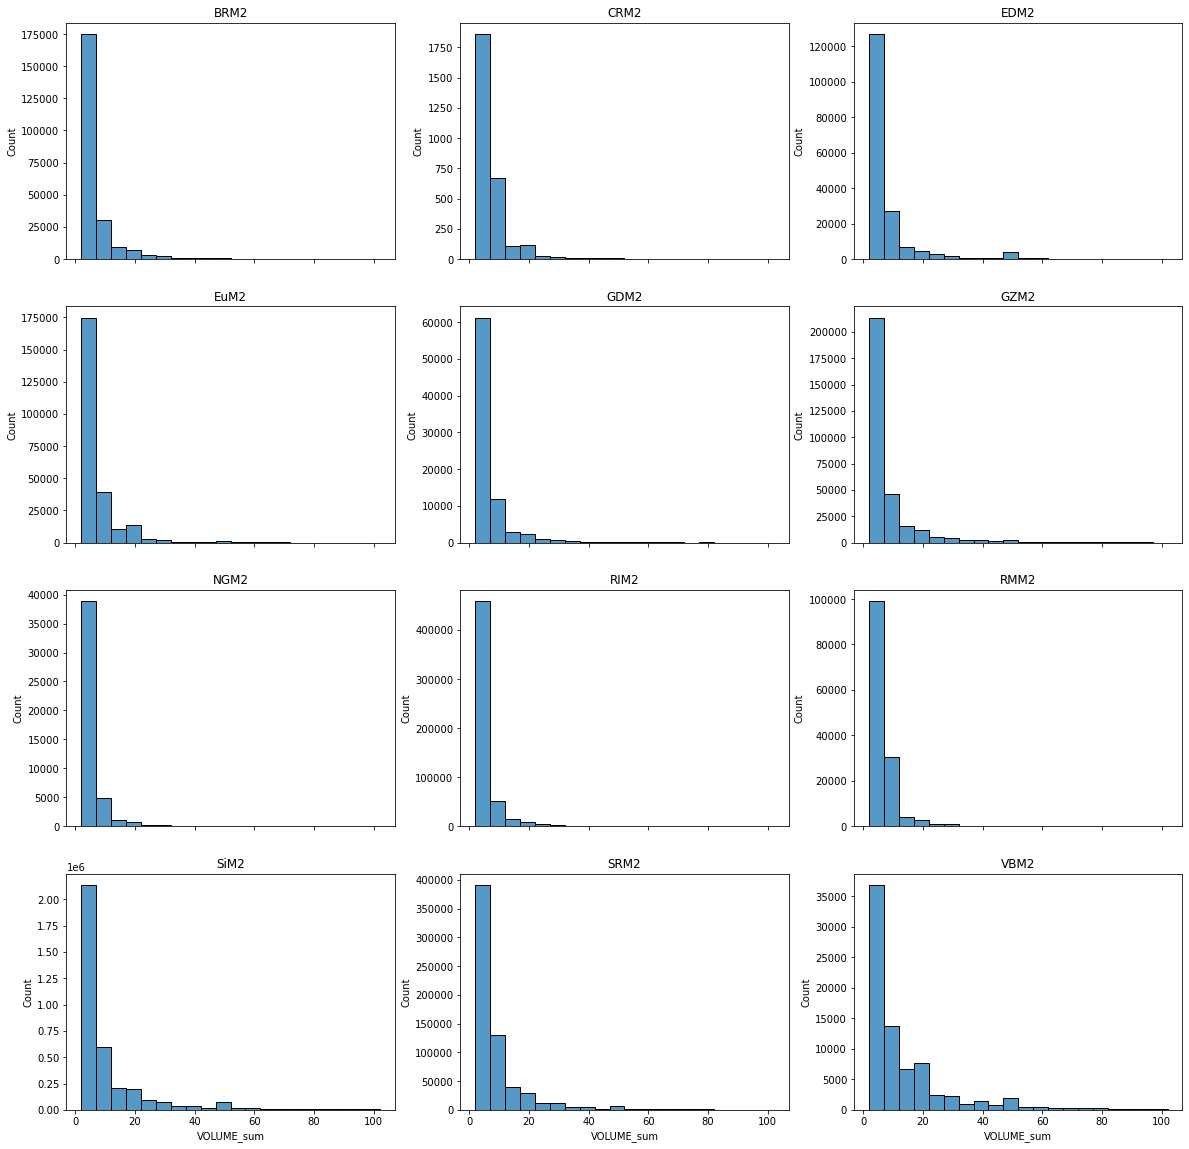

In [6]:
fig, axises = plt.subplots(4, 3, figsize=(20, 20), sharex=True)
i_subplot = 0

for file_name in files:
    df = pd.read_feather(f'./data/{file_name}').query(common_filters)
    sns.histplot(data=df, x='VOLUME_sum', ax=axises.flat[i_subplot], binwidth=5)
    axises.flat[i_subplot].title.set_text(file_name[:file_name.find('.feather')])
    i_subplot += 1

### Stairs

<AxesSubplot:xlabel='VOLUME_sum', ylabel='Count'>

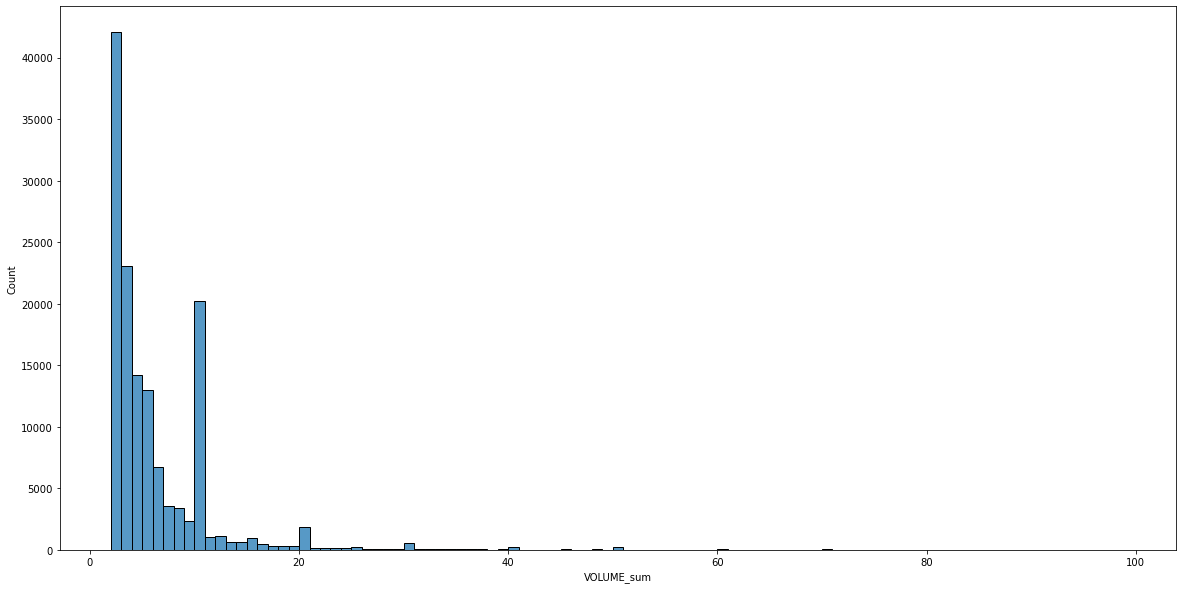

In [7]:
plt.figure(figsize=(20, 10))

df = pd.read_feather(f'./data/RMM2.feather').query(common_filters)
sns.histplot(data=df, x='VOLUME_sum', binwidth=1)

### CCDF plots

In [8]:
exclusions = [10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 300, 400, 500]

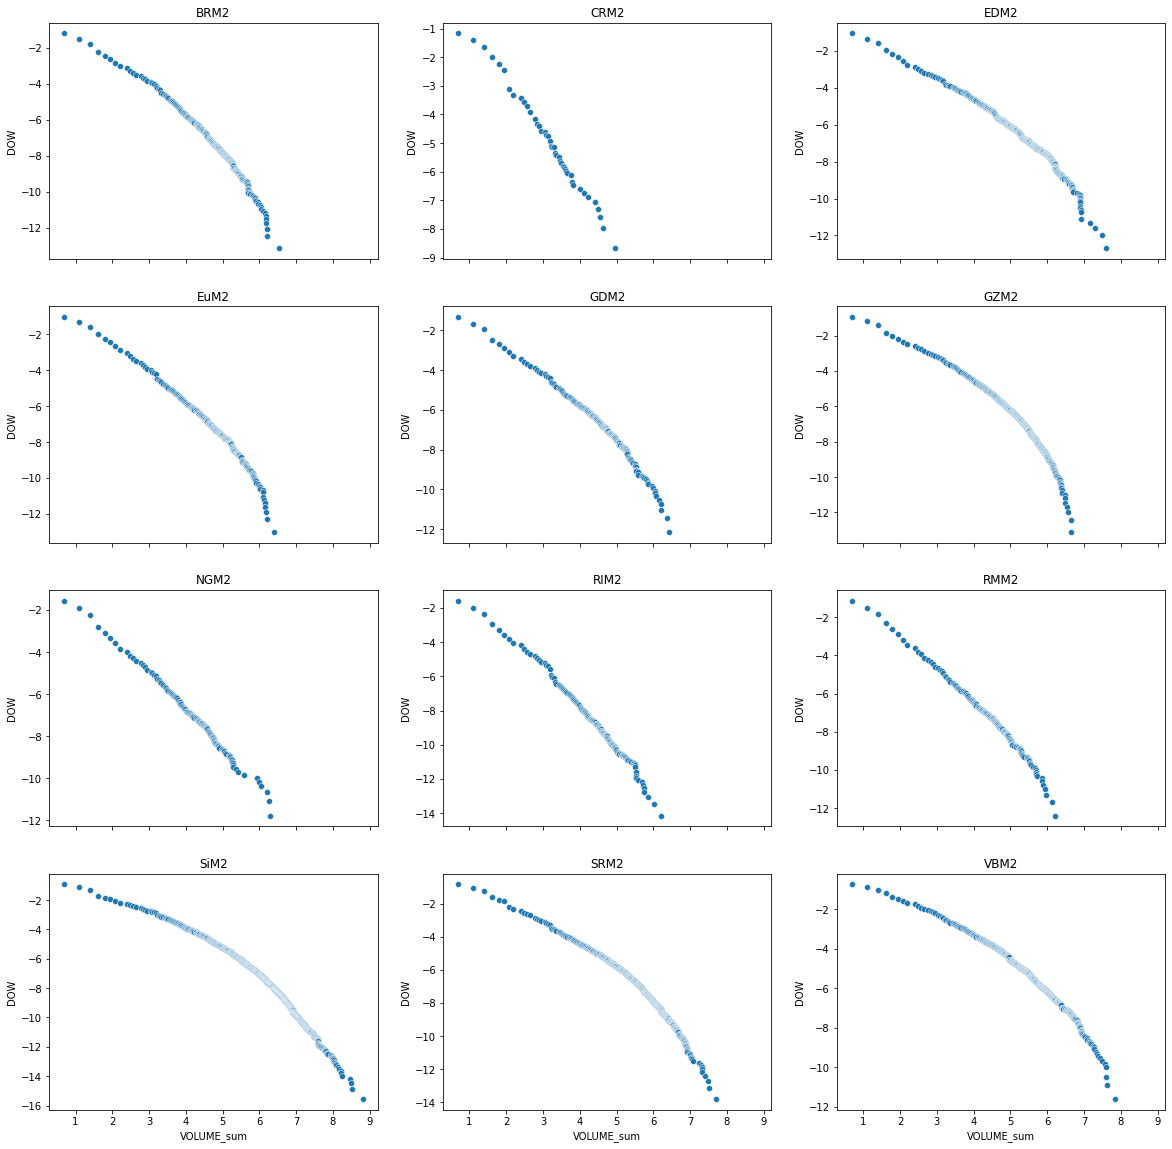

In [9]:
fig, axises = plt.subplots(4, 3, figsize=(20, 20), sharex=True)
i_subplot = 0

i_subplot = 0
for file_name in files:
    df = pd.read_feather(f'./data/{file_name}')
    df = df[~df['VOLUME_sum'].isin(exclusions)]
    XY = df[['VOLUME_sum', 'DOW']].groupby(by=['VOLUME_sum'], as_index=True, sort=True)\
        .count()['DOW']
    ccdf = 1. - np.cumsum(XY / np.sum(XY))
    X, Y = XY[1:-1].index, ccdf[1:-1]
    
    sns.scatterplot(x=np.log(X), y=np.log(Y), ax=axises.flat[i_subplot])
    axises.flat[i_subplot].title.set_text(file_name[:file_name.find('.feather')])
    i_subplot += 1

### Regressions

In [10]:
def add2results(ticker, res, df):
    df.loc[ticker, 'R2'] = res.rsquared_adj
    df.loc[ticker, 'F-stat p-value'] = res.f_pvalue
    df.loc[ticker, 'Alpha'] = res.params[1]
    df.loc[ticker, 'Alpha p-value'] = res.pvalues[1]

In [11]:
def linreg(ticker, start=None, end=None, verbose=True, logx=True, logy=True, exclusions=None):
    df = pd.read_feather(f'./data/{ticker}.feather')
    if exclusions:
        df = df[~df['VOLUME_sum'].isin(exclusions)]

    XY = df[['VOLUME_sum', 'DOW']].groupby(by=['VOLUME_sum'], as_index=True, sort=True)\
        .count()['DOW']
    ccdf = 1. - np.cumsum(XY / np.sum(XY))
    
    X, Y = XY[1:-1].index, ccdf[1:-1]
        
    start = start if start else X[1]
    end = end if end else X[-1]    
    x = np.log(X) if logx else X
    y = np.log(Y) if logy else Y
    
    dxy = pd.DataFrame({'X': x[(X>=start) & (X<=end)], 
                        'Y': y[(X>=start) & (X<=end)]})
    model = gls('Y ~ X', data=dxy)
    res = model.fit() 
    
    if verbose:
        print(f'Origin range from {X[0]} till {X[-1]}')
        print(f'Regression range from {start} till {end}')

        sns.scatterplot(x, y)
        linregfunc = lambda x: res.params[0] + res.params[1]*x  # linear regression function
        xr = np.log([start, end]) if logx else np.array([start, end])
        sns.lineplot(xr, linregfunc(xr), color='r')
        
    return res

In [12]:
files

['BRM2.feather',
 'CRM2.feather',
 'EDM2.feather',
 'EuM2.feather',
 'GDM2.feather',
 'GZM2.feather',
 'NGM2.feather',
 'RIM2.feather',
 'RMM2.feather',
 'SiM2.feather',
 'SRM2.feather',
 'VBM2.feather']

In [13]:
# New result file
df_results = pd.DataFrame(columns=['R2', 'F-stat p-value', 'Alpha', 'Alpha p-value', 'start', 'end'])

Origin range from 2 till 494
Regression range from 5 till 494
R2                0.988922
F-stat p-value         0.0
Alpha            -2.400722
Alpha p-value          0.0
start                    5
end                   None
Name: RIM2, dtype: object


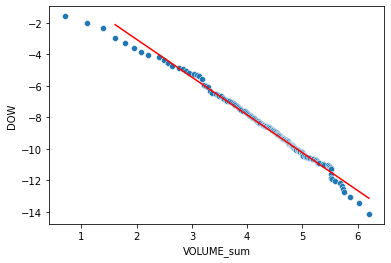

In [14]:
ticker = 'RIM2'
start, end = 5, None

res = linreg(ticker, start=start, end=end, exclusions=exclusions)
add2results(ticker, res, df_results)
df_results.loc[ticker, 'start'], df_results.loc[ticker, 'end'] = start, end
print(df_results.loc[ticker])

Origin range from 2 till 493
Regression range from 5 till 300
R2                0.993358
F-stat p-value         0.0
Alpha            -1.891514
Alpha p-value          0.0
start                    5
end                    300
Name: RMM2, dtype: object


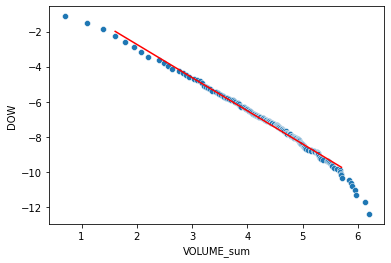

In [15]:
ticker = 'RMM2'
start, end = 5, 300

res = linreg(ticker, start=start, end=end, exclusions=exclusions)
add2results(ticker, res, df_results)
df_results.loc[ticker, 'start'], df_results.loc[ticker, 'end'] = start, end
print(df_results.loc[ticker])

Origin range from 2 till 2245
Regression range from 5 till 200
R2                0.995463
F-stat p-value         0.0
Alpha            -1.313251
Alpha p-value          0.0
start                    5
end                    200
Name: SRM2, dtype: object


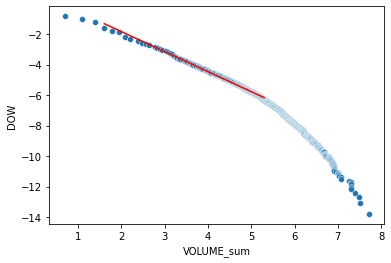

In [16]:
ticker = 'SRM2'
start, end = 5, 200

res = linreg(ticker, start=start, end=end, exclusions=exclusions)
add2results(ticker, res, df_results)
df_results.loc[ticker, 'start'], df_results.loc[ticker, 'end'] = start, end
print(df_results.loc[ticker])

Origin range from 2 till 2245
Regression range from 300 till 2245
R2                0.987271
F-stat p-value         0.0
Alpha            -2.964816
Alpha p-value          0.0
start                  300
end                   None
Name: SRM2, dtype: object


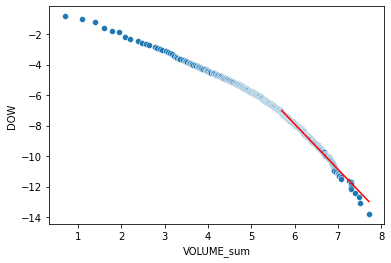

In [20]:
ticker = 'SRM2'
start, end = 300, None

res = linreg(ticker, start=start, end=end, exclusions=exclusions)
add2results(ticker, res, df_results)
df_results.loc[ticker, 'start'], df_results.loc[ticker, 'end'] = start, end
print(df_results.loc[ticker])

Origin range from 2 till 774
Regression range from 5 till 150
R2                0.984734
F-stat p-value         0.0
Alpha            -1.390676
Alpha p-value          0.0
start                    5
end                    150
Name: GZM2, dtype: object


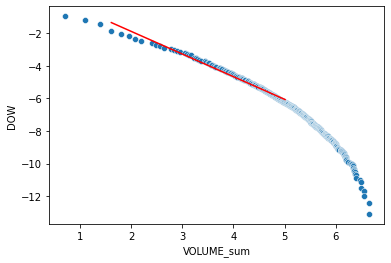

In [18]:
ticker = 'GZM2'
start, end = 5, 150

res = linreg(ticker, start=start, end=end, exclusions=exclusions)
add2results(ticker, res, df_results)
df_results.loc[ticker, 'start'], df_results.loc[ticker, 'end'] = start, end
print(df_results.loc[ticker])

Origin range from 2 till 774
Regression range from 200 till 774
R2                 0.95946
F-stat p-value         0.0
Alpha            -3.490999
Alpha p-value          0.0
start                  200
end                   None
Name: GZM2, dtype: object


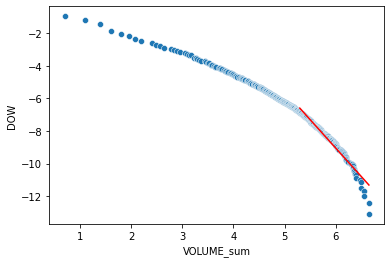

In [21]:
ticker = 'GZM2'
start, end = 200, None

res = linreg(ticker, start=start, end=end, exclusions=exclusions)
add2results(ticker, res, df_results)
df_results.loc[ticker, 'start'], df_results.loc[ticker, 'end'] = start, end
print(df_results.loc[ticker])

Origin range from 2 till 6673
Regression range from 200 till 4000
R2                0.990675
F-stat p-value         0.0
Alpha            -2.767269
Alpha p-value          0.0
start                  200
end                   4000
Name: SiM2, dtype: object


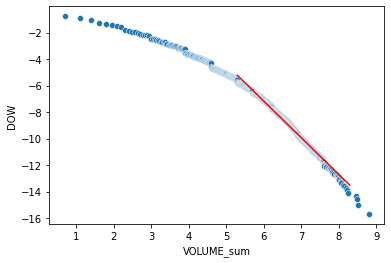

In [22]:
ticker = 'SiM2'
start, end = 200, 4000

res = linreg(ticker, start=start, end=end, exclusions=None)
add2results(ticker, res, df_results)
df_results.loc[ticker, 'start'], df_results.loc[ticker, 'end'] = start, end
print(df_results.loc[ticker])

Origin range from 2 till 6673
Regression range from 3 till 200
R2                0.984068
F-stat p-value         0.0
Alpha            -1.172859
Alpha p-value          0.0
start                    3
end                    200
Name: SiM2 10-200, dtype: object


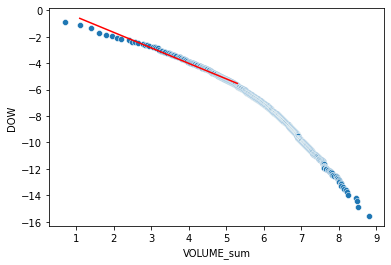

In [23]:
# Additional for low Si
ticker = 'SiM2'
start, end = 3, 200

res = linreg(ticker, start=start, end=end, exclusions=exclusions)
add2results(ticker+' 10-200', res, df_results)
df_results.loc[ticker+' 10-200', 'start'], df_results.loc[ticker+' 10-200', 'end'] = start, end
print(df_results.loc[ticker+' 10-200'])

Origin range from 2 till 592
Regression range from 3 till 300
R2                0.989448
F-stat p-value         0.0
Alpha            -1.846177
Alpha p-value          0.0
start                    3
end                    300
Name: EuM2, dtype: object


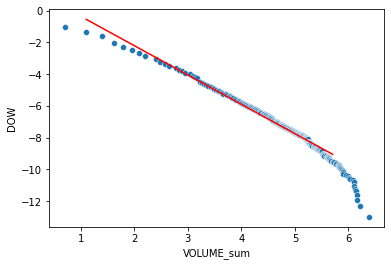

In [24]:
ticker = 'EuM2'
start, end = 3, 300

res = linreg(ticker, start=start, end=end, exclusions=exclusions)
add2results(ticker, res, df_results)
df_results.loc[ticker, 'start'], df_results.loc[ticker, 'end'] = start, end
print(df_results.loc[ticker])

Origin range from 2 till 2000
Regression range from 3 till 400
R2                0.989054
F-stat p-value         0.0
Alpha            -1.382709
Alpha p-value          0.0
start                    3
end                    400
Name: EDM2, dtype: object


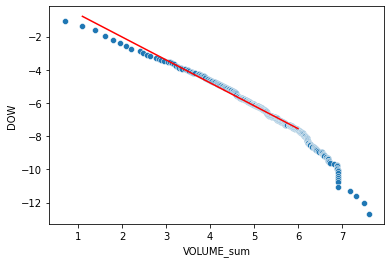

In [115]:
ticker = 'EDM2'
start, end = 3, 400

res = linreg(ticker, start=start, end=end, exclusions=exclusions)
add2results(ticker, res, df_results)
df_results.loc[ticker, 'start'], df_results.loc[ticker, 'end'] = start, end
print(df_results.loc[ticker])

Origin range from 2 till 143
Regression range from 3 till 100
R2                 0.99314
F-stat p-value         0.0
Alpha            -1.882087
Alpha p-value          0.0
start                    3
end                    100
Name: CRM2, dtype: object


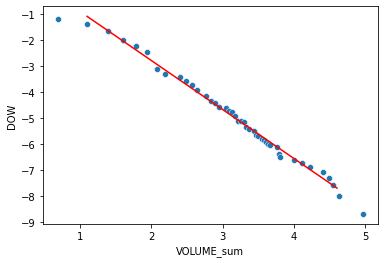

In [116]:
ticker = 'CRM2'
start, end = 3, 100

res = linreg(ticker, start=start, end=end, exclusions=exclusions)
add2results(ticker, res, df_results)
df_results.loc[ticker, 'start'], df_results.loc[ticker, 'end'] = start, end
print(df_results.loc[ticker])

Origin range from 2 till 691
Regression range from 20 till 300
R2                0.991573
F-stat p-value         0.0
Alpha            -2.211076
Alpha p-value          0.0
start                   20
end                    300
Name: BRM2, dtype: object


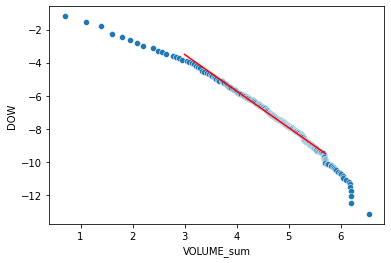

In [26]:
ticker = 'BRM2'
start, end = 20, 300

res = linreg(ticker, start=start, end=end, exclusions=exclusions)
add2results(ticker, res, df_results)
df_results.loc[ticker, 'start'], df_results.loc[ticker, 'end'] = start, end
print(df_results.loc[ticker])

Origin range from 2 till 691
Regression range from 3 till 25
R2                0.995343
F-stat p-value         0.0
Alpha            -1.224832
Alpha p-value          0.0
start                    3
end                     25
Name: BRM2 5-25, dtype: object


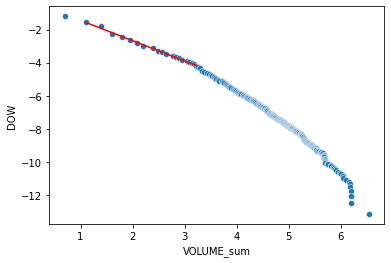

In [25]:
# Low BR
ticker = 'BRM2'
start, end = 3, 25

res = linreg(ticker, start=start, end=end, exclusions=exclusions)
add2results(ticker+ ' 5-25', res, df_results)
df_results.loc[ticker+ ' 5-25', 'start'], df_results.loc[ticker+ ' 5-25', 'end'] = start, end
print(df_results.loc[ticker+ ' 5-25'])

Origin range from 2 till 623
Regression range from 5 till 300
R2                0.980536
F-stat p-value         0.0
Alpha            -1.691274
Alpha p-value          0.0
start                    5
end                    300
Name: GDM2, dtype: object


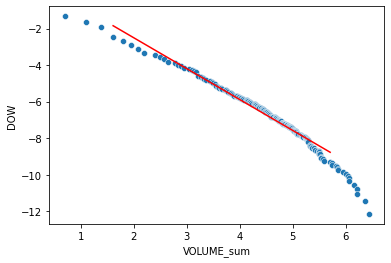

In [27]:
ticker = 'GDM2'
start, end = 5, 300

res = linreg(ticker, start=start, end=end, exclusions=exclusions)
add2results(ticker, res, df_results)
df_results.loc[ticker, 'start'], df_results.loc[ticker, 'end'] = start, end
print(df_results.loc[ticker])

Origin range from 2 till 534
Regression range from 3 till 500
R2                0.992761
F-stat p-value         0.0
Alpha             -1.84422
Alpha p-value          0.0
start                    3
end                    500
Name: NGM2, dtype: object


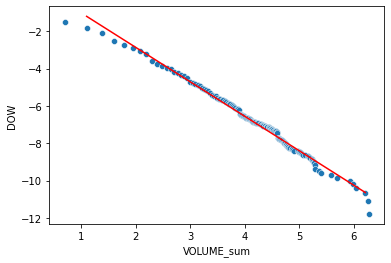

In [120]:
ticker = 'NGM2'
start, end = 3, 500

res = linreg(ticker, start=start, end=end)
add2results(ticker, res, df_results)
df_results.loc[ticker, 'start'], df_results.loc[ticker, 'end'] = start, end
print(df_results.loc[ticker])

### Results

In [28]:
df_results

,R2,F-stat p-value,Alpha,Alpha p-value,start,end
RIM2,0.988922,0.0,-2.400722,0.0,5,None
RMM2,0.993358,0.0,-1.891514,0.0,5,300
SRM2,0.987271,0.0,-2.964816,0.0,300,None
GZM2,0.95946,0.0,-3.490999,0.0,200,None
SiM2,0.990675,0.0,-2.767269,0.0,200,4000
SiM2 10-200,0.984068,0.0,-1.172859,0.0,3,200
EuM2,0.989448,0.0,-1.846177,0.0,3,300
BRM2 5-25,0.995343,0.0,-1.224832,0.0,3,25
BRM2,0.991573,0.0,-2.211076,0.0,20,300
GDM2,0.980536,0.0,-1.691274,0.0,5,300


In [122]:
df_results.to_csv('alphas_results')